import numpy as np
import pandas as pd
import xarray as xr
import math

In [15]:
# this can be run in venv climates_env in opt/anaconda3/envs   
# at the home directory run Ana.sh  -> conda info --envs -> conda activate climates_env
# xemsf can be install only via conda install (not pip)

import numpy as np 
import pandas as pd 
import xarray as xr 
#import math
import matplotlib.pyplot as plt
from cmcrameri import cm
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
import matplotlib.colors as mcolors
#import matplotlib.image as mpimg
#from scipy.interpolate import RegularGridInterpolator
from scipy.ndimage import generic_filter

import xesmf as xe


In [16]:
ds = xr.open_dataset("Emission_grid_all.nc", engine="netcdf4")



In [17]:
path2cams = 'CAMS-GLOB-ANT_Glb_0.1x0.1_anthro_nox_v6.2_yearly_2010.nc'
camsds = xr.open_dataset(path2cams)

# 1. データセット全体にNaNがあるか
has_nan = np.isnan(camsds.to_array()).any()
print("NaNがあるか:", has_nan)

# 2. 各変数ごとにNaNの数を確認
for var in camsds.data_vars:
    n_nan = camsds[var].isnull().sum().item()  # .item() でスカラーとして表示
    print(f"{var} のNaNの数: {n_nan}")

#camsds = camsds.squeeze().sel(lon=slice(lon_min-1, lon_max+1), lat=slice(lat_min-1, lat_max+1))
print(camsds)

NaNがあるか: <xarray.DataArray ()> Size: 1B
array(False)
Attributes: (12/13)
    Conventions:        CF-1.6
    projection:         latlon
    authors:            A. Soulie and C. Granier
    description:        Monthly nox expressed as nitric oxide emissions based...
    product_version:    v6.2
    title:              CAMS Global anthropogenic emissions
    ...                 ...
    source:             EDGARv6 emissions up to 2018 CAMS-GLOB-TEMPOv2.1/v3.2...
    creation_date:      2023-11-21 UTC
    NCO:                netCDF Operators version 5.1.4 (Homepage = http://nco...
    distribution_date:  2025-10-14
    references:         Soulie, A., Granier, C., Darras, S., Zilbermann, N., ...
    history:            Tue Oct 14 15:20:07 2025: ncatted -O -a distribution_...
agl のNaNの数: 0
ags のNaNの数: 0
awb のNaNの数: 0
com のNaNの数: 0
ene のNaNの数: 0
fef のNaNの数: 0
gridcell_area のNaNの数: 0
ind のNaNの数: 0
ref のNaNの数: 0
res のNaNの数: 0
shp のNaNの数: 0
sum のNaNの数: 0
swd のNaNの数: 0
tnr のNaNの数: 0
tro のNaNの数: 0


In [18]:
def centers_to_edges(arr):
    d = np.diff(arr)
    edges = np.empty(len(arr) + 1)
    edges[1:-1] = arr[:-1] + d / 2
    edges[0] = arr[0] - d[0] / 2
    edges[-1] = arr[-1] + d[-1] / 2
    return edges

def get_latlon_array(lat_range,lon_range):  # lon_range = [lon_min, lon_max], lat_range = [lat_min, lat_max]
     
    lat_range = np.array(lat_range)
    lon_range  = np.array(lon_range)
    
    lat_range_grid = np.ceil(lat_range * 120) * 1/120
    lon_range_grid = np.ceil(lon_range * 80) * 1/80

    #print(lat_range_grid)
    #print(lon_range_grid)
    
    lat_array = np.arange(lat_range_grid[0],lat_range_grid[1] + 1/120,  1/120 )
    lon_array  = np.arange(lon_range_grid[0],lon_range_grid[1] + 1/120 ,  1/80 )
    
    lat_array = np.round(lat_array, 5)
    lon_array = np.round(lon_array ,5)

    return lon_array, lat_array

In [19]:
# the input lon, lat is the center of 5 x 5 grid 
def cams_make(lon, lat, camsds,cams_pix = 5):
  
    # squeeze in case there are time/level dims
    camsds = camsds.squeeze()

    # get full CAMS coordinates
    src_lon = camsds['lon'].values
    src_lat = camsds['lat'].values
    src_val = 1e9 * 1e-2 * camsds['sum'].values  # (nlat, nlon)

    # --- 1. find nearest CAMS grid cell to (lon, lat) ---
    ix0 = np.argmin(np.abs(src_lon - lon))
    iy0 = np.argmin(np.abs(src_lat - lat))

    # --- 2. build 5x5 window around it ---
    half = cams_pix // 2  # =2

    ix = np.arange(ix0 - half, ix0 + half + 1)
    iy = np.arange(iy0 - half, iy0 + half + 1)

    # clip to domain (safety)
    ix = ix[(ix >= 0) & (ix < len(src_lon))]
    iy = iy[(iy >= 0) & (iy < len(src_lat))]

    # actual CAMS grid centers
    cams_lon_array = src_lon[ix]
    cams_lat_array = src_lat[iy]

    # extract CAMS emission subgrid
    cams_emission = src_val[np.ix_(iy, ix)]  # (5,5) if not at boundary

    #print("CAMS lon centers:", cams_lon_array)
    #print("CAMS lat centers:", cams_lat_array)
    #print("CAMS subgrid shape:", cams_emission.shape)
    # plt.imshow(cams_emission)
    # plt.show()
   
    return cams_lon_array, cams_lat_array, cams_emission


In [20]:

def eagrid_make_xesmf(cams_lon_array, cams_lat_array,cams_emission, k, sector = "All_sources", source = 'NOx'):
    # = make downscaled grid made from original cams grid
    dlon = np.abs(cams_lon_array[1] - cams_lon_array[0])
    dlat = np.abs(cams_lat_array[1] - cams_lat_array[0])

    # build fine grid covering the 5 CAMS cells
    lon_min = cams_lon_array[0] - dlon / 2
    lon_max = cams_lon_array[-1] + dlon / 2
    lat_min = cams_lat_array[0] - dlat / 2
    lat_max = cams_lat_array[-1] + dlat / 2

    fine_dlon = dlon / k
    fine_dlat = dlat / k

    # The lat lon is the center of grid
    eagrid_lon_array = np.round(np.linspace(lon_min + fine_dlon/2, lon_max - fine_dlon/2, 5 * k), 4)
    eagrid_lat_array = np.round(np.linspace(lat_min + fine_dlat/2, lat_max - fine_dlat/2, 5 * k), 4)
    
    # Lon, Lat = np.meshgrid(eagrid_lon_array, eagrid_lat_array)
    # value_grid = np.zeros(Lon.shape, dtype = float)  # data will be stored 
    # area_grid  = np.zeros_like(value_grid) # area of overlap will be stored

    # print(f"cams_lat_array {len(cams_lat_array), cams_lat_array}")
    # print(f" first eagrid_lat_arra {eagrid_lat_array[0]}")
    # print(f" end eagrid_lat_array {eagrid_lat_array[-5:]}")
    # print(f" len of eagrid_lon_array {len(eagrid_lon_array)}")
    # print(f"first of eagrid_lon_array {eagrid_lon_array[:5]}")

    # == From here eagrid data is read == 
    sec_idx = int(ds.sector.to_index().get_loc(sector))
    src_idx = int(ds.source.to_index().get_loc(source))

    lat_e = ds["lat"].values
    lon_e = ds["lon"].values
    emission = ds["Emission"][sec_idx, src_idx, :].values

    # == mask ====
    # get a range from lat_array and lon_array
    margin = 0.05
    lat_min, lat_max = eagrid_lat_array[0], eagrid_lat_array[-1]
    lon_min, lon_max = eagrid_lon_array[0], eagrid_lon_array[-1]
    mask = (lat_e >= lat_min - margin) & (lat_e <= lat_max + margin) & \
           (lon_e >= lon_min - margin) & (lon_e <= lon_max + margin)
    # extract # lat_in, lon_in are left bottom
    lat_in = lat_e[mask]
    lon_in = lon_e[mask]

    emission_in = emission[mask]

    # # only keep points with no multiple values
    # coords = np.column_stack((lon_in,lat_in))
    # _, unique_idx = np.unique(coords, axis=0, return_index=True)

    # lon_in = lon_in[unique_idx]
    # lat_in = lat_in[unique_idx]
    # emission_in = emission_in[unique_idx]

    # TODO currently hard-corded, needs to be revisited
    #dlat_e = 1/240
    #dlon_e = 1/160
    lon_e_edges , lat_e_edges = get_latlon_array([lat_min , lat_max ],[lon_min , lon_max])  #
    lon_e_center = lon_e_edges + 1/160
    lat_e_center = lat_e_edges + 1/240

    # add the right top bound
    lon_e_edges_xe = np.append(lon_e_edges, lon_e_edges[-1] + 1/80)
    lat_e_edges_xe = np.append(lat_e_edges, lat_e_edges[-1] + 1/120)
    
    #lat_e_edges = np.concatenate([lat_in - dlat_e, [lat_in.max() + dlat_e]])
    #lon_e_edges = np.concatenate([lon_in, [lon_in.max() + dlon_e]])
    #print(f" 10min eagrid nc's lon edges {lon_in[:10]}")
    #print(f" first  lon_e_edges, {lon_e_edges[:5]}")
    #print(f" end 5 of lon_e_edges, {lon_e_edges[-5:]}")
    #print(f"len of lot_e_edges {len(lon_e_edges)}")
    #print('')
    #print(f" first 5 of lat_e_edges, {lat_e_edges[:5]}")
    #print(f" end 5 of lat_e_edges, {lat_e_edges[-5:]}")
   # == Put emission in (point data into 2d array) ==
    Lon_in, Lat_in = np.meshgrid(lon_e_edges, lat_e_edges)
    emission_grid = np.full(Lon_in.shape, np.nan)
    for lon, lat, val in zip(lon_in, lat_in, emission_in):
        i = np.argmin(np.abs(lat_e_edges - lat))
        # print(lat_array[i]- lat)   < = This is all 0, means lat_array made in def get_latlon_array is align with nc grid
        j = np.argmin(np.abs(lon_e_edges - lon))
    #     if abs(lat_array[i] - lat) <= lat_half and abs(lon_array[j] - lon) <= lon_half:
        emission_grid[i, j] = val
        #print(val)
   # == =========
    #print(emission_grid.shape)
    #plt.imshow(emission_grid)
    #plt.show()

    # make the edge lon and lat of target grid (high reso but align eith cams)
    # to calculate the overlap between eagrid emission grid
    #print(f" len of eagrid_lon_array {len(eagrid_lon_array)}")
    #print(f" len of eagrid_lat_array {len(eagrid_lat_array)}")
    lat_t_edges = centers_to_edges(eagrid_lat_array)
    lon_t_edges = centers_to_edges(eagrid_lon_array)
    cams_lat_array_edges = centers_to_edges(cams_lat_array)
    cams_lon_array_edges = centers_to_edges(cams_lon_array)
    #print(f"first of lon e and t  {lon_e_edges[0], lon_t_edges[0]}")
    #print(f"end   of lon e and t {lon_e_edges[-1], lon_t_edges[-1]}")

    #print(f"first of lat e and t  {lat_e_edges[0], lat_t_edges[0]}")
    #print(f"end   of lat e and t {lat_e_edges[-1], lat_t_edges[-1]}")

   # print(f"len of lat_t_edges {len(lat_t_edges)}")
   # print(f"len of lon_t_edges {len(lon_t_edges)}")
    # grid_in =  {'lon': lon_e_center, 'lat': lat_e_center}
    # grid_out = {'lon': eagrid_lon_array, 'lat': eagrid_lat_array}

    #regridder = xe.Regridder(grid_in,grid_out, 'conservative')
    # print(lon_e_center.shape)
    # print(lat_e_center.shape)
    # print(lon_e_edges.shape)
    # print(lat_e_edges.shape)
    # print(eagrid_lon_array.shape)
    # print(eagrid_lat_array.shape)
    # print(lon_t_edges.shape)
    # print(lat_t_edges.shape)
    # print(cams_lon_array.shape)
    # print(cams_lat_array.shape)
    # print(cams_lon_array_edges.shape)
    # print(cams_lat_array_edges.shape)
    
    # print(emission_grid.shape)
    # print(cams_emission.shape)
    # For emission grid

    # replace nan to 0
    emission_grid = np.nan_to_num(emission_grid, nan=0.0)

    grid_in = {"lon": lon_e_center, 
               "lat": lat_e_center,
               "lon_b": lon_e_edges_xe,
               "lat_b": lat_e_edges_xe}

    grid_out = {"lon": eagrid_lon_array, 
                  "lat": eagrid_lat_array,
                  "lon_b": lon_t_edges,
                  "lat_b": lat_t_edges}
    #grid_in_cams = {"lon": cams_lon_array, "lat": cams_lat_array}
    regridder = xe.Regridder(grid_in, grid_out, 'conservative')
    value_grid = regridder(emission_grid)

    # For CAMS grid conserv
    grid_in_cams ={"lon": cams_lon_array, 
                   "lat": cams_lat_array,
                   "lon_b": cams_lon_array_edges,
                   "lat_b": cams_lat_array_edges
    }
    regridder_cams_interp  = xe.Regridder(grid_in_cams, grid_out, 'bilinear',extrap_method="nearest_s2d")
    fine_cams_emission_interp = regridder_cams_interp(cams_emission)

    regridder_cams_conserv = xe.Regridder(grid_in_cams, grid_out,'conservative')
    fine_cams_emission_conserv = regridder_cams_conserv(cams_emission)



    print("cams before :", np.nansum(cams_emission))
    print("cams after :", np.nansum(fine_cams_emission_conserv)/ 100)
    print('')
    print("xe eagrid Before:", np.nansum(emission_grid))
    print("xe eagrid After: ", np.nansum(value_grid)* 24 /25)

    #plt.imshow(value_grid)
    #plt.show()

    return lon_e_edges, lat_e_edges, emission_grid, eagrid_lon_array, eagrid_lat_array, value_grid, fine_cams_emission_interp, fine_cams_emission_conserv

    # they are ok 
    # print("lat edges:", lat_t_edges[:5], "...", lat_t_edges[-5:])
    # print("lon edges:", lon_t_edges[:5], "...", lon_t_edges[-5:])
    # print("target lat centers:", eagrid_lat_array[:5], eagrid_lat_array[-5:])
    # print("target lon centers:", eagrid_lon_array[:5], eagrid_lon_array[-5:])
    return eagrid_lon_array, eagrid_lat_array, value_grid
        


In [21]:

def eagrid_make2(cams_lon_array, cams_lat_array, k, sector = "All_sources", source = 'NOx'):
    # = make downscaled grid made from original cams grid
    dlon = np.abs(cams_lon_array[1] - cams_lon_array[0])
    dlat = np.abs(cams_lat_array[1] - cams_lat_array[0])

    # build fine grid covering the 5 CAMS cells
    lon_min = cams_lon_array[0] - dlon / 2
    lon_max = cams_lon_array[-1] + dlon / 2
    lat_min = cams_lat_array[0] - dlat / 2
    lat_max = cams_lat_array[-1] + dlat / 2

    fine_dlon = dlon / k
    fine_dlat = dlat / k

    # The lat lon is the center of grid
    # eagrid_lon_array = np.round(np.arange(lon_min + fine_dlon/2 , lon_max + 0.5 * fine_dlon , fine_dlon), 4)
    # eagrid_lat_array =np.round(np.arange(lat_min + fine_dlat/2, lat_max + 0.5 * fine_dlat , fine_dlat),4)

    
    eagrid_lon_array = np.round(np.linspace(lon_min + fine_dlon/2, lon_max - fine_dlon/2, 5 * k), 4)
    eagrid_lat_array = np.round(np.linspace(lat_min + fine_dlat/2, lat_max - fine_dlat/2, 5 * k), 4)
    
    Lon, Lat = np.meshgrid(eagrid_lon_array, eagrid_lat_array)
    value_grid = np.zeros(Lon.shape, dtype = float)  # data will be stored 
    area_grid  = np.zeros_like(value_grid) # area of overlap will be stored

    # print(f"cams_lat_array {len(cams_lat_array), cams_lat_array}")
    # print(f" first eagrid_lat_arra {eagrid_lat_array[0]}")
    # print(f" end eagrid_lat_array {eagrid_lat_array[-5:]}")
    # print(f" len of eagrid_lon_array {len(eagrid_lon_array)}")
    # print(f"first of eagrid_lon_array {eagrid_lon_array[:5]}")

    # == From here eagrid data is read == 
    sec_idx = int(ds.sector.to_index().get_loc(sector))
    src_idx = int(ds.source.to_index().get_loc(source))

    lat_e = ds["lat"].values
    lon_e = ds["lon"].values
    emission = ds["Emission"][sec_idx, src_idx, :].values

    # == mask ====
    # get a range from lat_array and lon_array
    margin = 0.05
    lat_min, lat_max = eagrid_lat_array[0], eagrid_lat_array[-1]
    lon_min, lon_max = eagrid_lon_array[0], eagrid_lon_array[-1]
    mask = (lat_e >= lat_min - margin) & (lat_e <= lat_max + margin) & \
           (lon_e >= lon_min - margin) & (lon_e <= lon_max + margin)
    # extract # lat_in, lon_in are left bottom
    lat_in = lat_e[mask]
    lon_in = lon_e[mask]

    emission_in = emission[mask]

    # # only keep points with no multiple values
    # coords = np.column_stack((lon_in,lat_in))
    # _, unique_idx = np.unique(coords, axis=0, return_index=True)

    # lon_in = lon_in[unique_idx]
    # lat_in = lat_in[unique_idx]
    # emission_in = emission_in[unique_idx]

    # TODO currently hard-corded, needs to be revisited
    #dlat_e = 1/240
    #dlon_e = 1/160
    lon_e_edges , lat_e_edges = get_latlon_array([lat_min , lat_max ],[lon_min , lon_max])
    #lat_e_edges = np.concatenate([lat_in - dlat_e, [lat_in.max() + dlat_e]])
    #lon_e_edges = np.concatenate([lon_in, [lon_in.max() + dlon_e]])
    #print(f" 10min eagrid nc's lon edges {lon_in[:10]}")
    #print(f" first  lon_e_edges, {lon_e_edges[:5]}")
    #print(f" end 5 of lon_e_edges, {lon_e_edges[-5:]}")
    #print(f"len of lot_e_edges {len(lon_e_edges)}")
    #print('')
    #print(f" first 5 of lat_e_edges, {lat_e_edges[:5]}")
    #print(f" end 5 of lat_e_edges, {lat_e_edges[-5:]}")
   # == Put emission in (point data into 2d array) ==
    Lon_in, Lat_in = np.meshgrid(lon_e_edges, lat_e_edges)
    emission_grid = np.full(Lon_in.shape, np.nan)
    for lon, lat, val in zip(lon_in, lat_in, emission_in):
        i = np.argmin(np.abs(lat_e_edges - lat))
        # print(lat_array[i]- lat)   < = This is all 0, means lat_array made in def get_latlon_array is align with nc grid
        j = np.argmin(np.abs(lon_e_edges - lon))
    #     if abs(lat_array[i] - lat) <= lat_half and abs(lon_array[j] - lon) <= lon_half:
        emission_grid[i, j] = val
        #print(val)
   # == =========
    #print(emission_grid.shape)
    #plt.imshow(emission_grid)
    #plt.show()

    # make the edge lon and lat of target grid (high reso but align eith cams)
    # to calculate the overlap between eagrid emission grid
    #print(f" len of eagrid_lon_array {len(eagrid_lon_array)}")
    #print(f" len of eagrid_lat_array {len(eagrid_lat_array)}")
    lat_t_edges = centers_to_edges(eagrid_lat_array)
    lon_t_edges = centers_to_edges(eagrid_lon_array)
    print(f"first of lon e and t  {lon_e_edges[0], lon_t_edges[0]}")
    print(f"end   of lon e and t {lon_e_edges[-1], lon_t_edges[-1]}")

    print(f"first of lat e and t  {lat_e_edges[0], lat_t_edges[0]}")
    print(f"end   of lat e and t {lat_e_edges[-1], lat_t_edges[-1]}")

   # print(f"len of lat_t_edges {len(lat_t_edges)}")
   # print(f"len of lon_t_edges {len(lon_t_edges)}")


    #print(f"edge and center {lon_t_edges, eagrid_lon_array}")
    # loop for all emisson grid
    for i in range(len(lat_e_edges)-1):
        for j in range(len(lon_e_edges)-1):
            # boundary from emission data
            e_lat0 = lat_e_edges[i]
            e_lat1 = lat_e_edges[i +1]
            e_lon0 = lon_e_edges[j]
            e_lon1 = lon_e_edges[j+1]
            
            emis = emission_grid[i, j]
            if np.isnan(emis):
                continue
                
            # index of target gird where lat lon of emission includes
            ti0 = np.searchsorted(lat_t_edges, e_lat0) - 1
            ti1 = np.searchsorted(lat_t_edges, e_lat1) 
            tj0 = np.searchsorted(lon_t_edges, e_lon0) - 1
            tj1 = np.searchsorted(lon_t_edges, e_lon1) 

            #print(f"tj0, tj1 {tj0,tj1}")
            
            # for all emission grids which is overlap to a certain target grid

            
            for ti in range(ti0, ti1):
                for tj in range(tj0, tj1):
                    

                    # if something wrong, skip calculation 
                    
                    if ti < 0 or tj < 0 or ti >= value_grid.shape[0] or tj >= value_grid.shape[1]:
                        print("skip the ti and tj loop")
                    
                        continue
                    # lon lat of target grid    
                    t_lat0 = lat_t_edges[ti]
                    t_lat1 = lat_t_edges[ti+1]
                    t_lon0 = lon_t_edges[tj]
                    t_lon1 = lon_t_edges[tj+1]   
                
                    
                    overlap_lon = min(e_lon1, t_lon1) - max(e_lon0, t_lon0)
                    
                    if overlap_lon <= 1e-20:
                        #print("overlap_lon <= 0")
                        continue
                        
                    overlap_lat = min(e_lat1, t_lat1) - max(e_lat0, t_lat0)
                    
                    if overlap_lat <= 1e-20:
                        #print("overlap_lat <=0")
                        continue

                    
                    # == original version ====
                    # put the eission data into value grid 
                    overlap_area = overlap_lon * overlap_lat
                    # emission area and fraction
                    e_area = (e_lat1 - e_lat0) * (e_lon1 - e_lon0)             
                    frac = overlap_area / e_area
                    
                    #print(f" frac {frac}")  # This is not 0
                    value_grid[ti, tj] += emis * frac
                    area_grid[ti, tj]  += overlap_area
                    # # ==-==================
            #print(" ")
    print("original Before:", np.nansum(emission_grid))
    print("Original After: ", np.nansum(value_grid))

    #plt.imshow(value_grid)
    #plt.show()

    return lon_e_edges, lat_e_edges, emission_grid, eagrid_lon_array, eagrid_lat_array, value_grid

    # they are ok 
    # print("lat edges:", lat_t_edges[:5], "...", lat_t_edges[-5:])
    # print("lon edges:", lon_t_edges[:5], "...", lon_t_edges[-5:])
    # print("target lat centers:", eagrid_lat_array[:5], eagrid_lat_array[-5:])
    # print("target lon centers:", eagrid_lon_array[:5], eagrid_lon_array[-5:])
    return eagrid_lon_array, eagrid_lat_array, value_grid
        


In [22]:

def fill_nan_mean(data, size=10):
    data = data.copy()

    def nanmean_filter(values):
        vals = values[~np.isnan(values)]
        return np.mean(vals) if len(vals) > 0 else np.nan

    # 周囲平均を計算（全体に対して）
    mean_filtered = generic_filter(
        data,
        nanmean_filter,
        size=size,
        mode='constant',
        cval=0
    )

    # 🔥 NaN の場所だけ置き換える
    mask = np.isnan(data)
    data[mask] = mean_filtered[mask]

    return data


In [38]:
cams_pix = 5
#cams_lon_array, cams_lat_array, cams_emission= cams_make(135.725, 34.900,  camsds, cams_pix)
cams_lon_array, cams_lat_array, cams_emission= cams_make(139.6917,  35.68,  camsds, cams_pix)

cams before : 1.2539481e+06
cams after : 1.2540251e+06

xe eagrid Before: 174115714.6040727
xe eagrid After:  168888870.3799631


/var/folders/b2/4zv441n11_s6ww9psppcn0s80000gn/T/ipykernel_53798/869758331.py:56: RuntimeWarning: divide by zero encountered in log10
  sc = ax.pcolormesh(lon_e_edges, lat_e_edges, np.log10(emission_grid),
/var/folders/b2/4zv441n11_s6ww9psppcn0s80000gn/T/ipykernel_53798/869758331.py:67: RuntimeWarning: divide by zero encountered in log10
  sc = ax.pcolormesh(eagrid_lon_array, eagrid_lat_array, np.log10(value_grid),


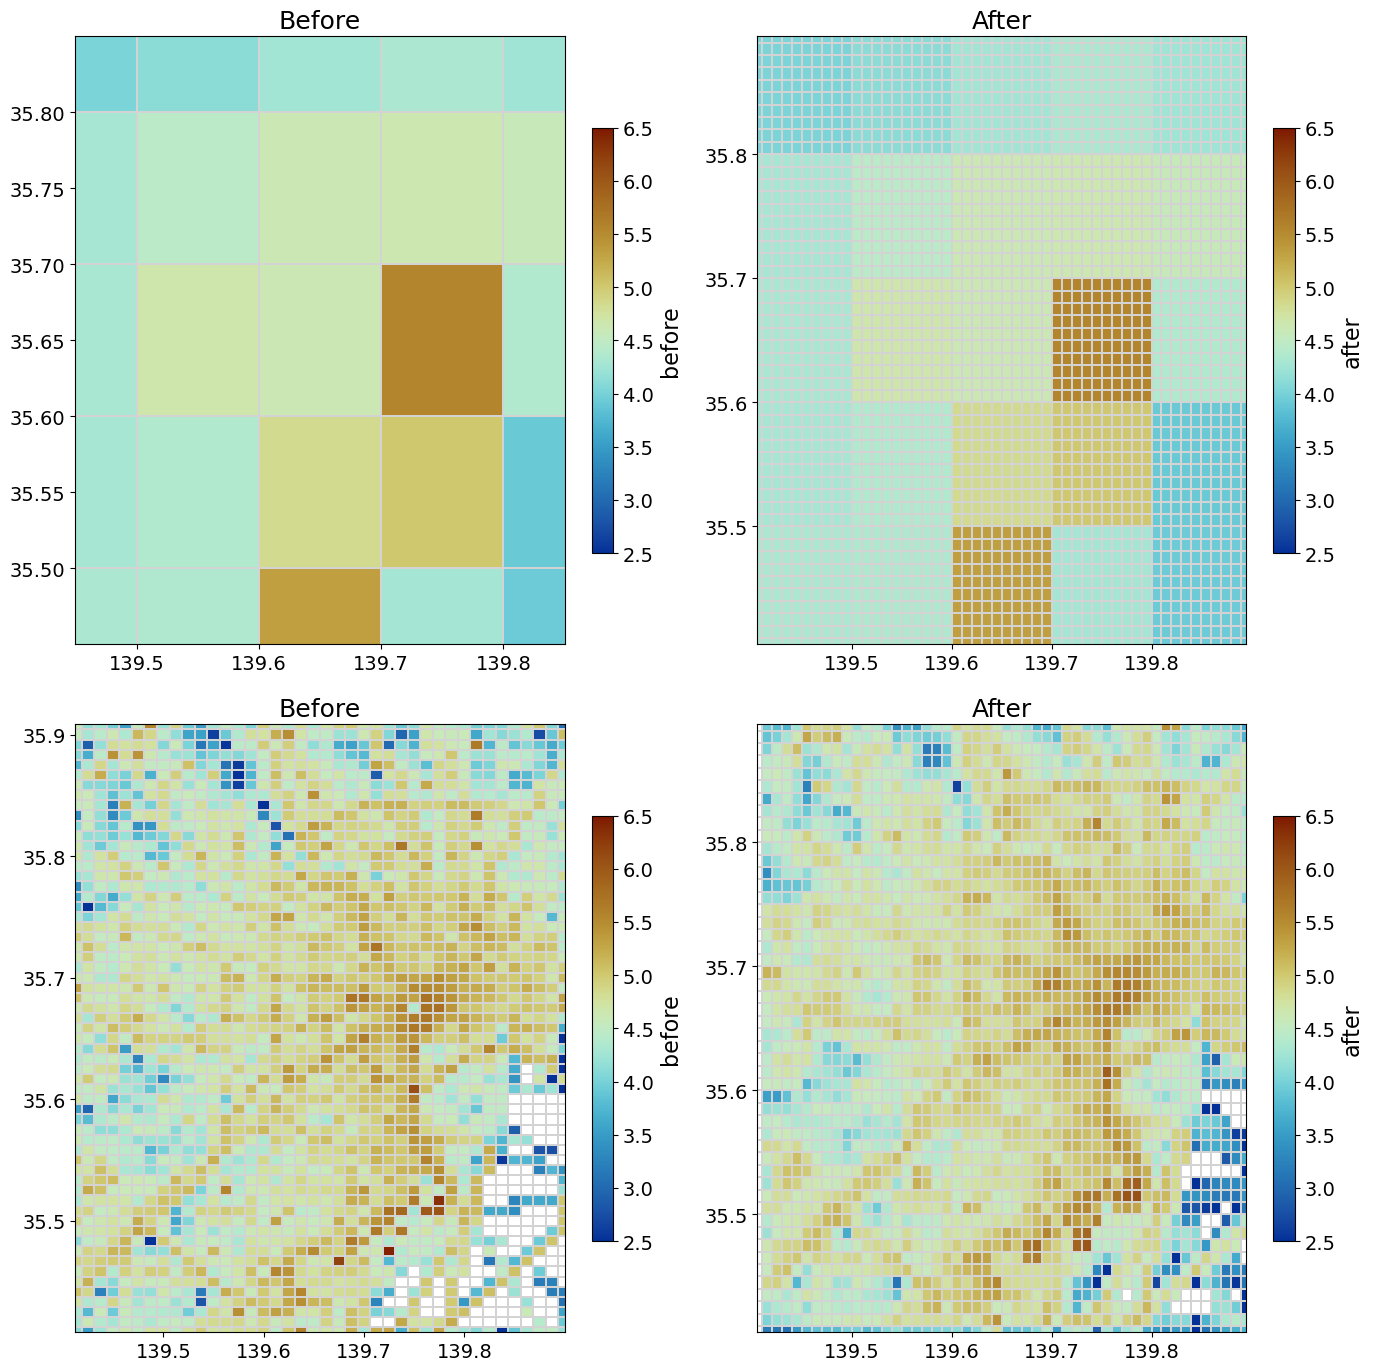

before fill 0


In [ ]:
lon_e_edges, lat_e_edges, emission_grid, eagrid_lon_array, eagrid_lat_array, value_grid, fine_cams_emission_interp, fine_cams_emission_conserv = eagrid_make_xesmf(cams_lon_array,cams_lat_array, cams_emission,10,  sector = "All_sources", source = 'NOx')
# value_grid_fill = fill_nan_mean(value_grid, size=10)
# cams compare 
import matplotlib as mpl

mpl.rcParams.update({
    "font.size": 16,          # base size
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.titlesize": 20,
})
log_ticks = np.arange(2.5, 6.6, 1.0)  # 2.5, 3.5, ..., 6.5
tick_labels = [rf"$10^{{{t:.1f}}}$" for t in log_ticks]


fig, axes = plt.subplots(2, 2, figsize=(14, 14))  # 横並び2列、各7x7相当

# ------------------- CAMS before -------------------
ax = axes[0,0]
cmap = cm.roma_r
norm = mcolors.Normalize(vmin=2.5, vmax=6.5)

sc = ax.pcolormesh(cams_lon_array, cams_lat_array, np.log10(cams_emission),
                   cmap=cmap, norm=norm,
                   edgecolors='lightgray', linewidth=0.2)
ax.set_aspect('auto')

ax.set(xlim=[cams_lon_array[0], cams_lon_array[-1]], ylim=[cams_lat_array[0], cams_lat_array[-1]])
cb = plt.colorbar(sc, ax=ax, shrink=0.7, aspect=20, fraction=0.046)
#cb.ax.tick_params(labelsize=7)
cb.set_ticks(log_ticks)
cb.set_ticklabels(tick_labels)
cb.set_label('before')
ax.set_title('Before')

# ------------------- CAMS after -------------------
ax = axes[0,1]
sc = ax.pcolormesh(eagrid_lon_array, eagrid_lat_array, np.log10(fine_cams_emission_conserv),
                   cmap=cmap, norm=norm,
                   edgecolors='lightgray', linewidth=0.2)
ax.set(xlim=[eagrid_lon_array[0], eagrid_lon_array[-1]], ylim=[eagrid_lat_array[0], eagrid_lat_array[-1]])
cb = plt.colorbar(sc, ax=ax, shrink=0.7, aspect=20, fraction=0.046)
#cb.ax.tick_params(labelsize=7)
cb.set_ticks(log_ticks)
cb.set_ticklabels(tick_labels)
cb.set_label('after')
ax.set_title('After')
# plt.title('CAMS')
# plt.tight_layout()
# plt.show()



# == EAGrids before and after regridding =======
#fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # 横並び2列、各7x7相当

# -------------------EAGRid before -------------------
ax = axes[1,0]
cmap = cm.roma_r
norm = mcolors.Normalize(vmin=2.5, vmax=6.5)

sc = ax.pcolormesh(lon_e_edges, lat_e_edges, np.log10(emission_grid),
                   cmap=cmap, norm=norm,
                   edgecolors='lightgray', linewidth=0.2)
ax.set(xlim=[lon_e_edges[0], lon_e_edges[-1]], ylim=[lat_e_edges[0], lat_e_edges[-1]])
ax.set_aspect('auto')

cb = plt.colorbar(sc, ax=ax, shrink=0.7, aspect=20, fraction=0.046)
#cb.ax.tick_params(labelsize=7)
cb.set_ticks(log_ticks)
cb.set_ticklabels(tick_labels)
cb.set_label('before')
ax.set_title('Before')

# -------------------EAgrid after -------------------
ax = axes[1,1]
sc = ax.pcolormesh(eagrid_lon_array, eagrid_lat_array, np.log10(value_grid),
                   cmap=cmap, norm=norm,
                   edgecolors='lightgray', linewidth=0.2)
ax.set(xlim=[eagrid_lon_array[0], eagrid_lon_array[-1]], ylim=[eagrid_lat_array[0], eagrid_lat_array[-1]])
ax.set_aspect('auto')

cb = plt.colorbar(sc, ax=ax, shrink=0.7, aspect=20, fraction=0.046)
cb.set_ticks(log_ticks)
cb.set_ticklabels(tick_labels)

#cb.ax.tick_params(labelsize=7)
cb.set_label('after')
ax.set_title('After')

# # == ==== fill =======
# ax = axes[2]
# sc = ax.pcolormesh(eagrid_lon_array, eagrid_lat_array, value_grid,
#                    cmap=cmap, 
#                    edgecolors='lightgray', linewidth=0.2)
# ax.set(xlim=[eagrid_lon_array[0], eagrid_lon_array[-1]], ylim=[eagrid_lat_array[0], eagrid_lat_array[-1]])
# cb = plt.colorbar(sc, ax=ax, shrink=0.7, aspect=20, fraction=0.046)
# cb.ax.tick_params(labelsize=7)
# cb.set_label('after', fontsize=7)
# ax.set_title('After', fontsize=10)

# plt.title('After fill')
plt.tight_layout()
plt.show()
print(f'before fill {np.isnan(value_grid).sum()}')
#print(f'after fill {np.isnan(value_grid_fill).sum()}')

In [32]:
# function for augumentation
def augment_square(img):
    """Return list of augmented images (D4: 8 variants)"""
    imgs = []
    for k in range(4):
        r = np.rot90(img, k)
        imgs.append(r)
        imgs.append(np.fliplr(r))
    return imgs
# function of fill nan with the average of surrounding pixels


# files = sorted(os.listdir(img_path_train_high))

# for fname in files:
#     # load
#     img_h = np.array(Image.open(os.path.join(img_path_train_high, fname)))
#     img_l = np.array(Image.open(os.path.join(img_path_train_low, fname)))

#     # augmentation (same transform!)
#     aug_h = augment_square(img_h)
#     aug_l = augment_square(img_l)

#     # save
#     base, ext = os.path.splitext(fname)
#     for i, (h, l) in enumerate(zip(aug_h, aug_l)):
#         Image.fromarray(h).save(f"{out_high}/{base}_aug{i}{ext}")
#         Image.fromarray(l).save(f"{out_low}/{base}_aug{i}{ext}")

In [26]:
def make_testdata(camsds, ds, cams_pix,  scale_factor , sector = "All_sources", source = 'NOx'):
    # == eagrid data read ===
    sec_idx = int(ds.sector.to_index().get_loc(sector))
    src_idx = int(ds.source.to_index().get_loc(source))

    lat_e = ds["lat"].values
    lon_e = ds["lon"].values
    emission = ds["Emission"][sec_idx, src_idx, :].values

    #lat_e_uni = np.unique(lat_e)
    #lon_e_uni = np.unique(lon_e)
    #emission_2d = emission.reshape(len(lat_e_uni),len(lon_e_uni))
    
    min_lon = np.min(lon_e)
    max_lon = np.max(lon_e)
    min_lat = np.min(lat_e)
    max_lat = np.max(lat_e)
    
    # ==========================
    lon_array = np.arange(min_lon , max_lon , 0.1)  #  cams grid is 0.1 degree
    lat_array = np.arange(min_lat , max_lat , 0.1)

    print(f"before removed {len(lon_array) , len(lat_array)}")

    dataset_lon_array = []   # THE array for the center lon lat of image, which has almost all data (less nan)
    dataset_lat_array = []
    
    # making the lon lat (center of grid) array that has enough data in the pixels
    for lon in lon_array:
        for lat in lat_array:
            half_size = cams_pix * 0.1 / 2  # as 5x5 of cams pixel, the hald degree is 0.25
            dlat = np.abs(lat_e - lat)
            dlon = np.abs(lon_e - lon)
            
            mask = (dlat <= half_size) & (dlon <= half_size)
         
            #print(f"len of mask (True count): {np.sum(mask)}")

            sub_points = emission[mask]
            # total is how many data in the image
            # It should be 2500
            total = sub_points.size   

            #print(f'total {total}')
            if total == 0:
                continue
            if np.nansum(sub_points) < 100:
                continue

            
            #invalid_mask = np.isnan(sub_points) | (sub_points == 0)
            #ratio_invalid = invalid_mask.sum() / total

            # if ratio_invalid < 0.5:
            #     dataset_lon_array.append(lon)
            #     dataset_lat_array.append(lat)
            if total > 1750:
                dataset_lon_array.append(lon)
                dataset_lat_array.append(lat)
           
                
    print(f"len of LON LAT {len(dataset_lon_array), len(dataset_lat_array)}")            

    num_dataset = len(dataset_lon_array)
    
    # lon lat array cams and eagrid 
    # eagrid array is tcreated from cams so, they are aligned.
    center_lon_lat_drop = [] # 2d (num of dataset after dropped, 2) center lon lat
    cams_lon_c_array_drop = []  # 2d (num of dataset after dropped, 5) center of grid 
    cams_lat_c_array_drop = []  # 2d (num of dataset after dropped, 5) center of grid
    eagrid_lon_c_array_drop = [] # 2d (num of dataset after dropped, 50)
    eagrid_lat_c_array_drop = [] # 2d (num of dataset after dropped, 50)
    cams_dataset_drop= []  # 3d (num of dataset after dropped, 50, 50)
    cams_interp_xe_drop = [] # 3d (num of dataset after dropped, 50, 50)
    cams_conserv_xe_drop = [] # 3d (num of dataset after dropped, 50, 50)
    eagrid_dataset_drop = []   # 3d (num of dataset after dropped, 50, 50)


    # Augumentarion array 
    cams_dataset_drop_aug = []
    cams_interp_xe_drop_aug = []
    cams_conserv_xe_drop_aug = []
    eagrid_dataset_drop_aug = []
    #diff_array = np.zeros(num_dataset)
    #diff_array_xe = np.zeros(num_dataset) 
    diff_array = []
    
    for i, (lon, lat) in enumerate(zip(dataset_lon_array, dataset_lat_array)):
        print(f"{lon:.3f}, {lat:.3f}")
        cams_lon_array, cams_lat_array, cams_emission = cams_make(lon, lat,  camsds, cams_pix)
        lon_e_edges_xe, lat_e_edges_xe, emission_grid_xe, eagrid_lon_array_xe, eagrid_lat_array_xe, value_grid_xe, fine_cams_emission_xe_interp, fine_cams_emission_xe_conserv = eagrid_make_xesmf(cams_lon_array,cams_lat_array,cams_emission, 10,  sector = "All_sources", source = 'NOx')
        #lon_e_edges, lat_e_edges, emission_grid, eagrid_lon_array, eagrid_lat_array, value_grid = eagrid_make2(cams_lon_array,cams_lat_array, 10,  sector = "All_sources", source = 'NOx')
        
        # here, after regrid, fill nan by surrounding pixel average
        #value_grid_xe = fill_nan_mean(value_grid_xe, size=5)
        value_grid_xe = np.nan_to_num(value_grid_xe, nan=0.0)

        rsdiff_xe = np.sqrt((np.nansum(value_grid_xe) - np.nansum(emission_grid_xe))**2) / np.nansum(emission_grid_xe)
        
        # drop if regredding does not work well
        if rsdiff_xe < 0.02:
            
            center_lon_lat_drop.append([lon, lat])
            cams_lon_c_array_drop.append(cams_lon_array)
            cams_lat_c_array_drop.append(cams_lat_array)
            eagrid_lon_c_array_drop.append(eagrid_lon_array_xe)
            eagrid_lat_c_array_drop.append(eagrid_lat_array_xe)
            cams_dataset_drop.append(cams_emission)
            cams_interp_xe_drop.append(fine_cams_emission_xe_interp)
            cams_conserv_xe_drop.append(fine_cams_emission_xe_conserv)
            eagrid_dataset_drop.append(value_grid_xe)
        #rsdiff = np.sqrt((np.nansum(value_grid) - np.nansum(emission_grid))**2) / np.nansum(emission_grid)
            cams_dataset_drop_aug = cams_dataset_drop_aug + augment_square(cams_emission)
            cams_interp_xe_drop_aug = cams_interp_xe_drop_aug + augment_square(fine_cams_emission_xe_interp)
            cams_conserv_xe_drop_aug = cams_conserv_xe_drop_aug + augment_square(fine_cams_emission_xe_conserv)
            eagrid_dataset_drop_aug = eagrid_dataset_drop_aug + augment_square(value_grid_xe)

    center_lon_lat_drop = np.array(center_lon_lat_drop)        
    cams_lon_c_array_drop = np.array(cams_lon_c_array_drop)
    cams_lat_c_array_drop = np.array(cams_lat_c_array_drop)
    eagrid_lon_c_array_drop = np.array(eagrid_lon_c_array_drop)
    eagrid_lat_c_array_drop = np.array(eagrid_lat_c_array_drop)
    cams_dataset_drop = np.array(cams_dataset_drop)
    cams_interp_xe_drop = np.array(cams_interp_xe_drop)
    cams_conserv_xe_drop = np.array(cams_conserv_xe_drop)
    eagrid_dataset_drop = np.array(eagrid_dataset_drop)
    cams_dataset_drop_aug = np.array(cams_dataset_drop_aug)
    
    cams_dataset_drop_aug = np.array(cams_dataset_drop_aug)
    cams_interp_xe_drop_aug = np.array(cams_interp_xe_drop_aug)
    cams_conserv_xe_drop_aug = np.array(cams_conserv_xe_drop_aug)
    eagrid_dataset_drop_aug = np.array(eagrid_dataset_drop_aug)

    
    arrays = {
    "center_lon_lat": center_lon_lat_drop,
    "cams_lon_c_array": cams_lon_c_array_drop,
    "cams_lat_c_array": cams_lat_c_array_drop,
    "eagrid_lon_c_array": eagrid_lon_c_array_drop,
    "eagrid_lat_c_array": eagrid_lat_c_array_drop,
    "cams_dataset": cams_dataset_drop,
    "cams_interp_xe": cams_interp_xe_drop,
    "cams_conserv_xe": cams_conserv_xe_drop,
    "eagrid_dataset": eagrid_dataset_drop,
    "cams_dataset_aug": cams_dataset_drop_aug,
    "cams_interp_xe_aug": cams_interp_xe_drop_aug,
    "cams_conserv_xe_aug": cams_conserv_xe_drop_aug,
    "eagrid_dataset_aug": eagrid_dataset_drop_aug }

    for name, arr in arrays.items():
        np.save(f"{name}.npy", arr)    
        #diff_array[i] = rsdiff
        #diff_array_xe[i] = rsdiff_xe


    return np.array(diff_array)

        
   
    
    
        
    
                

[131.425  32.85 ]
(1191, 2) (1191, 50, 50) (1191, 50, 50)
0


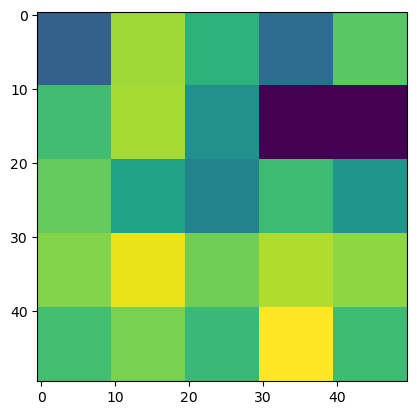

/var/folders/b2/4zv441n11_s6ww9psppcn0s80000gn/T/ipykernel_53798/851733710.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(eagrid[100, :,:]))


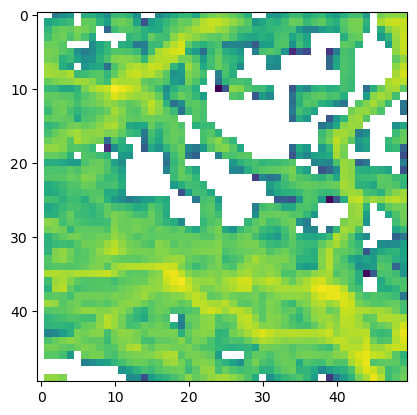

In [27]:
center_lon_lat = np.load('center_lon_lat.npy')
eagrid = np.load("eagrid_dataset.npy")
cams = np.load('cams_conserv_xe.npy')
print(center_lon_lat[100, :])
print(np.shape(center_lon_lat), np.shape(eagrid), np.shape(cams))

print(np.isnan(eagrid).sum())
plt.imshow(np.log10(cams[100, :,:]))
plt.show()
plt.imshow(np.log10(eagrid[100, :,:]))
plt.show()

In [28]:
diff_array = make_testdata(camsds,ds, 5, 10, "All_sources", "NOx")

a = diff_array[np.isfinite(diff_array)]
    #b = diff_array_xe[np.isfinite(diff_array_xe)]

    #vmin = min(a.min(), b.min())
#vmax = max(a.max(), b.max())
vmin = a.min()
vmax = a.max()
bins = np.linspace(0, 1, 50)

plt.figure(figsize=(7,5))

plt.hist(a, bins=bins, alpha=0.5, label="Original")
#plt.hist(b, bins=bins, alpha=0.5, label="xESMF")

# 平均線
plt.axvline(a.mean(), linestyle="--", linewidth=2, label=f"Original mean = {a.mean():.3f}")
#plt.axvline(b.mean(), linestyle="--", linewidth=2, label=f"xESMF mean = {b.mean():.3f}")

plt.xlabel("Relative difference")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hist_regrid.png')
plt.show()
    




before removed (312, 216)
len of LON LAT (3117, 3117)
129.825, 32.950
cams before : 135125.75
cams after : 135114.66

xe eagrid Before: 17604660.074630886
xe eagrid After:  16713403.578768225
129.825, 33.050
cams before : 132773.58
cams after : 132764.17

xe eagrid Before: 21795812.008961976
xe eagrid After:  15299632.317629475
129.825, 33.150
cams before : 170118.81
cams after : 170115.23

xe eagrid Before: 20327323.81296647
xe eagrid After:  19015211.856701575
129.825, 33.250
cams before : 91425.74
cams after : 91439.12

xe eagrid Before: 16284690.364924643
xe eagrid After:  15239922.876562504
129.925, 32.950
cams before : 62036.273
cams after : 62033.73

xe eagrid Before: 16930604.202625453
xe eagrid After:  16472501.809941337
129.925, 33.050
cams before : 60554.55
cams after : 60552.96

xe eagrid Before: 16097511.983213276
xe eagrid After:  15076920.959610147
129.925, 33.150
cams before : 97502.69
cams after : 97503.48

xe eagrid Before: 14464169.470219884
xe eagrid After:  1400678

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
print(diff_array)
print(diff_array_xe)
print(len(diff_array))

plt.plot(diff_array_xe)
plt.plot(diff_array)

plt.show()
a = diff_array[np.isfinite(diff_array)]
b = diff_array_xe[np.isfinite(diff_array_xe)]

vmin = min(a.min(), b.min())
vmax = max(a.max(), b.max())
bins = np.linspace(0, 1, 50)

plt.figure(figsize=(7,5))

plt.hist(a, bins=bins, alpha=0.5, label="Original")
plt.hist(b, bins=bins, alpha=0.5, label="xESMF")

# 平均線
plt.axvline(a.mean(), linestyle="--", linewidth=2, label=f"Original mean = {a.mean():.3f}")
plt.axvline(b.mean(), linestyle="--", linewidth=2, label=f"xESMF mean = {b.mean():.3f}")

plt.xlabel("Relative difference")
plt.ylabel("Probability density")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

[0.19742789 0.10964534 0.15925538 ... 0.01138867 0.05776042 0.11761946]


NameError: name 'diff_array_xe' is not defined

[131.425  32.85 ]
(1191, 2) (1191, 50, 50) (1191, 50, 50)


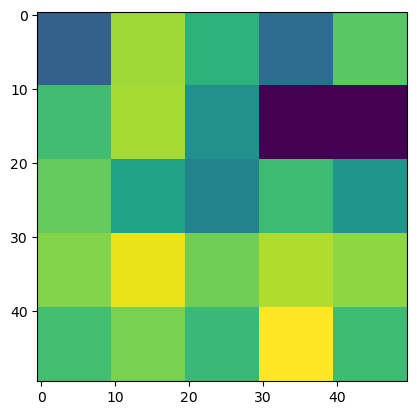

/var/folders/b2/4zv441n11_s6ww9psppcn0s80000gn/T/ipykernel_8018/2634326403.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(eagrid[100, :,:]))


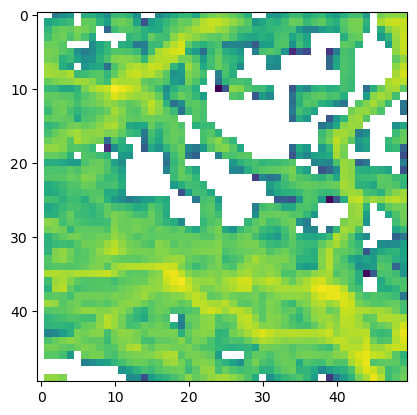